# Sentiment Analysis of COVID 19 vaccine tweets

The Covid19 pandemic has forced the entire world to be practically shut down for the larger part of the last year. The new year 2021 had brought with itself a new hope with the discoveries of various vaccines for the virus. A global vaccination drive is underway and the moment and we hope that the world will soon recover from this pandemic and normal lifestyles will be restored.

This notebook focuses on the tweets related to the vaccination drive. We use the BERT model and fine tune it on a twitter dataset containing 40K tweets. This is used to predict the sentiment of vaccination related tweets. We analyze the variations in the sentiment with respect to time, vaccine, and country.

<center><div>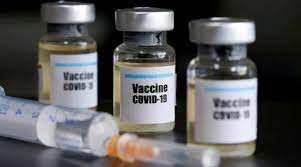</div></center>

**SETUP**

In [ ]:
pip install transformers

In [ ]:
import re
import numpy as np
import pandas as pd
import os, json
import torch
from sklearn.model_selection import train_test_split
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
import torch

if torch.cuda.is_available():    

    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

# Training the model

We use a general tweet sentiment analysis dataset in order to fine tune the BERT model. This dataset can be downloaded from this [link](https://www.kaggle.com/maxjon/complete-tweet-sentiment-extraction-data)

In [ ]:
df= pd.read_csv('/kaggle/input/complete-tweet-sentiment-extraction-data/tweet_dataset.csv')
df.head()

We select the useful coloumns from the dataset and make a new dataframe for training purpose.

In [ ]:
train= pd.DataFrame()
train['text']= df['text']
train['Sentiment']=df['new_sentiment']

In [ ]:
train=train.dropna()

In [ ]:
train.isnull().sum()

In [ ]:
train['Sentiment'] = train['Sentiment'].replace(['negative','neutral','positive'],[0,1,2])

**Importing the BERT Tokenizer**

In [ ]:
from transformers import BertTokenizer

print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [ ]:
print(tokenizer.tokenize("Hello. This is a sample statement for visualisation purposes"))

In [ ]:
print(tokenizer.convert_tokens_to_ids(tokenizer.tokenize("Hello. This is a sample statement for visualisation purposes")))

**Pre Processing**

In [ ]:
max_len = 0


for tweet in train['text']:
    
    # The following code is used to clean the tweets by removing URLs, accounts, quotation marks,etc
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    tweet = url_pattern.sub(r'', tweet)
    tweet = re.sub('\S*@\S*\s?', '', tweet)
    tweet = re.sub('\s+', ' ', tweet)
    tweet = re.sub("\'", "", tweet)

    input_ids = tokenizer.encode(tweet, add_special_tokens=True)

    max_len = max(max_len, len(input_ids))        #maximum length of input ids

print('Max sequence length: ', max_len)

In [ ]:

input_ids = []
attention_masks = []

for sent in train['text']:
    
    encoded_dict = tokenizer.encode_plus(
                        sent,                      
                        add_special_tokens = True, 
                        max_length = 110,           
                        pad_to_max_length = True,
                        return_attention_mask = True,   
                        return_tensors = 'pt',     
                   )
     
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])


input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(train['Sentiment'].tolist())

**Datasets and Dataloaders**

In [ ]:
from torch.utils.data import TensorDataset, random_split

dataset = TensorDataset(input_ids, attention_masks, labels)  #storing the input ids,masks and labels in dataset

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])  #90-10 train-val split

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler


batch_size = 32

train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset),     #random sampling in training
            batch_size = batch_size 
        )

validation_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset),    #sequential sampling in validation
            batch_size = batch_size 
        )

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig


model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", 
    num_labels = 3,   
    output_attentions = False,
    output_hidden_states = False,
)

**Optimizer and Scheduler**

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8 
                )

In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 4


total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

In [ ]:
import numpy as np

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    elapsed_rounded = int(round((elapsed)))
    
    return str(datetime.timedelta(seconds=elapsed_rounded))

**Training Loop**

In [ ]:
import random
import numpy as np


seed_val = 42
epochs=1

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

model.to(device)


training_stats = []

total_t0 = time.time()

for epoch_i in range(0, epochs):
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):
        
        # Printing the progress after every 40 epochs
        if step % 40 == 0 and not step == 0:
            
            elapsed = format_time(time.time() - t0)
            
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        total_train_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            

    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():        

            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        loss = result.loss
        logits = result.logits
            
        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)
        
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

# Sentiment Prediction

The covid 19 vaccination tweets dataset imported below can be downloaded from this [link](https://www.kaggle.com/gpreda/all-covid19-vaccines-tweets)

In [ ]:
df_vax = pd.read_csv('../input/all-covid19-vaccines-tweets/vaccination_all_tweets.csv')
df_vax

In [ ]:
vax_tweets= df_vax['text']

**Pre Processing the tweets**

In [ ]:

input_ids = []
attention_masks = []

for sent in vax_tweets:
    
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    tweet = url_pattern.sub(r'', tweet)
    tweet = re.sub('\S*@\S*\s?', '', tweet)
    tweet = re.sub('\s+', ' ', tweet)
    tweet = re.sub("\'", "", tweet)
    
    encoded_dict = tokenizer.encode_plus(
                        sent,                      
                        add_special_tokens = True, 
                        max_length = 110,           
                        pad_to_max_length = True,
                        return_attention_mask = True,   
                        return_tensors = 'pt',     
                   )
     
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])


input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

In [ ]:
vax_dataset= TensorDataset(input_ids, attention_masks)

batch_size = 32

vax_dataloader = DataLoader(
            vax_dataset,  
            sampler = SequentialSampler(vax_tweets),     #Sequential Sampling
            batch_size = batch_size 
        )

**Prediction**

In [ ]:
print('Predicting labels for {:,} vaccine tweets...'.format(len(input_ids)))

model.eval()

predictions = []

for batch in vax_dataloader:
 
  batch = tuple(t.to(device) for t in batch)
  
  b_input_ids, b_input_mask = batch

  with torch.no_grad():

      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  logits = logits.detach().cpu().numpy()
  
  logits=np.argmax(logits,axis=1)
  for i in range(len(logits)):
    predictions.append(logits[i])
    

print('    DONE.')

In [ ]:
df_vax['Sentiment'] = predictions
df_vax=df_vax.dropna()      #drops the null values

In [ ]:
df_vax.head()

We take only the coloumns which are useful for us

In [ ]:
vax= df_vax.drop(['user_name','user_description','user_created','user_followers','user_friends','user_favourites','source','is_retweet'],axis=1)

In [ ]:
vax.head()

In [ ]:
vax['Sentiment']=vax['Sentiment'].map({0:'negative',1:'neutral',2:'positive'})

In [ ]:
vax['Sentiment'].value_counts(normalize=True).plot.bar()

In [ ]:
vax['date'] = pd.to_datetime(vax['date'], errors='coerce').dt.date
vax['Sentiment'] = vax['Sentiment'].map({'negative':-1,'neutral':0,'positive':1})

In [ ]:
vax.head()

In [ ]:
all_vax = ['covaxin', 'sinopharm', 'sinovac', 'moderna', 'pfizer', 'biontech', 'oxford', 'astrazeneca', 'sputnik']

vax_sentiment = pd.DataFrame()
vax_sentiment['Vaccine']=all_vax
sentiments=list()

# Variance with Time

In [ ]:
def time_variance(vacc) :
    if vacc=='all':
        vacc=vax
    else :   
        vacc=vax[vax['text'].str.lower().str.contains(vacc)]
        sentiments.append(vacc.Sentiment.mean())

    temp=pd.DataFrame()
    temp['date'] = sorted(vacc['date'].unique())
    senti=list()

    for date in temp['date']:
        senti.append(vacc[vacc['date']==date].Sentiment.mean())

    temp['Sentiment']=senti
    
    fg,axs=plt.subplots(figsize=(15,7))
    sns.lineplot(ax=axs,x='date',y='Sentiment', data= temp)
    axs.set_xlabel("Time",size=16)
    axs.set_ylabel("Sentiment",size=16)
    axs.set_title("Variance of Sentiment wrt Time",size=24)
    axs.grid()

Mean overall sentiment

In [ ]:
time_variance('all')

**Covaxin**

In [ ]:
time_variance('covaxin')

**Sinopharm**

In [ ]:
time_variance('sinopharm')

**Sinovac**

In [ ]:
time_variance('sinovac')

**Moderna**

In [ ]:
time_variance('moderna')

**Pfizer**

In [ ]:
time_variance('pfizer')

**Biontech**

In [ ]:
time_variance('biontech')

**Oxford**

In [ ]:
time_variance('oxford')

**Astrazenca**

In [ ]:
time_variance('astrazeneca')

**Sputnik**

In [ ]:
time_variance('sputnik')

As a common trend in all vaccines, we can see that in the initial stages the sentiment seems to be on an extreme end. The positive extreme can be attributed to the celebration regarding the discovery of a vaccine whereas the negative extreme seems to be a result of popular rumours regarding the credibility of the vaccines. All the vaccines which had started with a negative sentiment have also achieved the positive sentiment extreme when the rumours regarding them were cancelled with concrete proof from the authorities. Gradually with the progress of the vaccination drive the sentiment tends to be more neutral

# Comparison amongst Vaccines

In [ ]:
vax_sentiment['Sentiment']=sentiments

fg,axs=plt.subplots(figsize=(15,7))
sns.barplot(ax=axs,x='Vaccine',y='Sentiment',data=vax_sentiment)
axs.set_xlabel("Vaccines",size=16)
axs.set_ylabel("Mean Sentiment",size=16)
axs.set_title("Mean Sentiment of Vaccines",size=24)

Biontech vaccine has recieved the best response among all these vaccines whereas astrazeneca has the lowest mean sentiment. It is a good thing to note that the mean sentiments for all the vaccines is positive.

# Comparison among countries

In [ ]:
country_sentiment=pd.DataFrame()
countries=['india','usa','canada','germany','spain','pakistan','uk','brazil','russia','italy','australia','france','argentina','uae','israel','mexico','japan']
country_sentiment['countries']=countries
senti=list()

for country in countries :
    senti.append(vax[vax['user_location'].str.lower().str.contains(country)].Sentiment.mean())
    
country_sentiment['Sentiment']=senti

In [ ]:
fg,axs=plt.subplots(figsize=(15,10))
sns.barplot(ax=axs,x='countries',y='Sentiment',data=country_sentiment)
axs.set_xlabel("Countries",size=16)
axs.set_ylabel("Mean Sentiment",size=16)
axs.set_title("Mean Sentiment of Countries",size=24)
axs.grid()

Most of the countries seem to have a positive sentiment towards the vaccination drive. However, Canada has a significantly negative sentiment and might be a cause for concern. Lets examine the variance of sentiment with respect to time in some of these countries.

# Varinace with Time in Different Countries

In [ ]:
def time_variance_country(country) :
    count=vax[vax['user_location'].str.lower().str.contains(country)]

    temp=pd.DataFrame()
    temp['date'] = sorted(count['date'].unique())
    senti=list()

    for date in temp['date']:
        senti.append(count[count['date']==date].Sentiment.mean())

    temp['Sentiment']=senti
    
    fg,axs=plt.subplots(figsize=(15,7))
    sns.lineplot(ax=axs,x='date',y='Sentiment', data= temp)
    axs.set_xlabel("Time",size=16)
    axs.set_ylabel("Sentiment",size=16)
    axs.set_title("Variance of Sentiment wrt Time",size=24)
    axs.grid()

**India**

In [ ]:
time_variance_country('india')

**Canada**(lowest mean sentiment)

In [ ]:
time_variance_country('canada')

**UAE**(highest mean sentiment)

In [ ]:
time_variance_country('uae')

**USA**

In [ ]:
time_variance_country('usa')

**Spain**

In [ ]:
time_variance_country('spain')

The variance of sentiment in the countries seems to be much more erratic than the one we observed for the case of different vaccines. However, the variation should be easily explained by the internal matters and/or politics of the respective countries. For example the sentiment in India seems to have been negative in the initial phases when the vaccines were available only for the frontline workers. However, the sentiment has improved after the vaccines were made publically available with the government ministers taking active participation as well for encouragement.

It falls on the governments all over the world to ensure that the general public has access to the vaccines. Also politicians and other influencers should stand united against this pandemic and refrain from dragging politics and rumors into this very sensitive and important aspect of human life.

# Conclusion

This notebook analyzes the sentiment of tweets related to the covid19 vaccination drive. We see the affect of widespread rumours that led to a highly negative sentiment in the beginning of the vaccination drive. However, with concrete proof showing the credibility of the vaccines, the vaccination drive is running in full swing all over the world.We also observe that the internal matters of a country also significantly affect the sentiment of the tweets. We hope that this vaccination drive ends in a success and we can see a sentiment spike in the coming months.

P.S: The dataset has tweets upto early May 2021 and this notebook does not represent any change in sentiment post this period.

# THANK YOU

Please comment your views and feedback.